In [22]:
import cv2 as cv2
import argparse
import numpy as np
import os.path
from matplotlib import pyplot as plt
%matplotlib inline

def imshow(tit, image) :
    plt.title(tit)    
    if len(image.shape) == 3 :
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    else :
        plt.imshow(image, cmap="gray")
    plt.show()

In [2]:
# Initialize the parameters 파라미터 초기설정
confThreshold = 0.5  #Confidence threshold 
nmsThreshold = 0.4   #Non-maximum suppression threshold 근처에 있는 애들을 같은 그룹으로 볼거냐
inpWidth = 416       #Width of network's input image
inpHeight = 416      #Height of network's input image

# Load names of classes
classesFile = "coco.names"
classes = None
with open(classesFile, 'rt') as f:
    classes = f.read().rstrip('\n').split('\n')
print(classes)
# Give the configuration and weight files for the model and load the network using them.
modelConfiguration = "yolov3.cfg" #yolo계층 3곳에서 classes변경/yolo계층 앞의 filters변경
modelWeights = "yolov3.weights" #filter에 대한 가중치

net = cv2.dnn.readNetFromDarknet(modelConfiguration, modelWeights)
net.setPreferableBackend(cv2.dnn.DNN_BACKEND_OPENCV)
net.setPreferableTarget(cv2.dnn.DNN_TARGET_CPU)

['person', 'bicycle', 'car', 'motorbike', 'aeroplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'sofa', 'pottedplant', 'bed', 'diningtable', 'toilet', 'tvmonitor', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']


In [24]:
def getOutputsNames(net): # Get the names of the output layers
    # Get the names of all the layers in the network
    layersNames = net.getLayerNames() #전체 네트워크를 구성하고있는 convolution
    # Get the names of the output layers, i.e. the layers with unconnected outputs
    return [layersNames[i[0] - 1] for i in net.getUnconnectedOutLayers()] #output 레이어 찾기
#yolo는 출력레이어(output) 총 3개
#print(net.getUnconnectedOutLayers()) =[[200],[227],[254]]   #2차원 배열 
#1부터 시작한다고 가정하므로 -1해줌(python은 0부터 시작) → [200-1 227-1 254-1] =yolo layers

def drawPred(classId, conf, left, top, right, bottom): #Draw the predicted bounding box
    cv2.rectangle(frame, (left, top), (right, bottom), (255, 178, 50), 3) #Draw a bounding box
    
    label = '%.2f' % conf #확률값 소수점 둘째자리까지 표시
    if classes: # Get the label for the class name and its confidence
        assert(classId < len(classes)) #실제 클래스 개수보다 작아야한다.
        label = '%s:%s' % (classes[classId], label) #classId에 해당하는 class를 가져옴

    #Display the label at the top of the bounding box   #박스 위에 label 표시
    labelSize, baseLine = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 1)
    top = max(top, labelSize[1])
    cv2.rectangle(frame, (left, top - round(1.5*labelSize[1])),
                  (left + round(1.5*labelSize[0]),top + baseLine),(255, 255, 255),cv2.FILLED)
    cv2.putText(frame, label, (left, top), cv2.FONT_HERSHEY_SIMPLEX, 0.75, (0,0,0), 1)

def postprocess(frame, outs): #Remove the b.boxes with low confidence using non-maxima suppression
    frameHeight = frame.shape[0] #행의 크기
    frameWidth = frame.shape[1] #열의 크기
    #Scan through all the bounding boxes output from the network and keep only the
    #ones with high confidence scores.
    #Assign the box's class label as the class with the highest score.
    classIds = []
    confidences = []
    boxes = []
    for out in outs: 
        for detection in out:
            scores = detection[5:] #85개 중에서 80개의 확률값을 가져와라
            classId = np.argmax(scores) #가장 값이 높은 곳의 index값
            confidence = scores[classId]
            if confidence > confThreshold:
                center_x = int(detection[0] * frameWidth)
                center_y = int(detection[1] * frameHeight)
                width = int(detection[2] * frameWidth)
                height = int(detection[3] * frameHeight)
                left = int(center_x - width / 2)
                top = int(center_y - height / 2)
                classIds.append(classId)
                confidences.append(float(confidence))
                boxes.append([left, top, width, height])
    #print(len(boxes))
#Perform non maximum suppression to eliminate redundant overlapping boxes with lower confidences.
    indices = cv2.dnn.NMSBoxes(boxes, confidences, confThreshold, nmsThreshold)
    for i in indices: #print(indices)
        i = i[0]
        box = boxes[i]
        left = box[0]
        top = box[1]
        width = box[2]
        height = box[3]
        drawPred(classIds[i], confidences[i], left, top, left + width, top + height)
#example) a=[[1],[2],[3]]
#for i in a:
#    print(i[0])=1 2 3

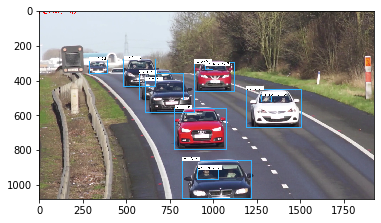

True

In [25]:
cap = cv2.VideoCapture('cars.jpg')

hasFrame, frame = cap.read()

blob = cv2.dnn.blobFromImage(frame, 1/255, (inpWidth, inpHeight), [0,0,0], 1, crop=False)
# 여기서 inpWidth는 영상의 크기가 아님.       #frame.shape[1] ~[0]   #평균
net.setInput(blob)

outs = net.forward(getOutputsNames(net))
#print(type(outs))='list' / print(len(outs))=3
#print(outs[0].shape)=507x85 yolo_82→507개의 b.box가 있음(13*13*3), 85=5+80
#print(outs[0][0])=yolo layer 1의 0번째 b.box의 정보
postprocess(frame, outs)

t, _ = net.getPerfProfile()
label = 'Inference time: %.2f ms' % (t * 1000.0 / cv2.getTickFrequency())
cv2.putText(frame, label, (0, 15), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255))

imshow("", frame)
cv2.imwrite("out.jpg", frame) 

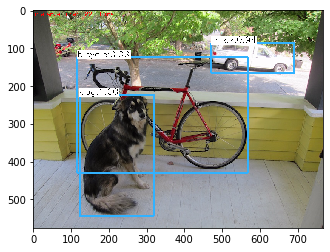

In [8]:
cv.imwrite("people.jpg", frame) 
img = cv.cvtColor(frame, cv.COLOR_BGR2RGB)
plt.imshow(img)

<img src=out.jpg>

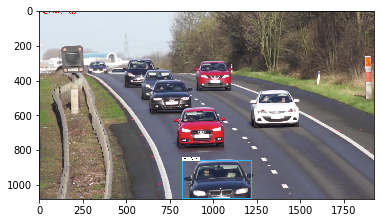

True

In [17]:
#yolo_82 layer(0번째 출력 레이어)의 실습
def postprocess(frame, outs): 
    frameHeight = frame.shape[0] 
    frameWidth = frame.shape[1] 

    classIds = []
    confidences = []
    boxes = []
    for detection in outs[0]: 
        scores = detection[5:]
        classId = np.argmax(scores) 
        confidence = scores[classId]
        if confidence > 0.01:
            center_x = int(detection[0] * frameWidth)
            center_y = int(detection[1] * frameHeight)
            width = int(detection[2] * frameWidth)
            height = int(detection[3] * frameHeight)
            left = int(center_x - width / 2)
            top = int(center_y - height / 2)
            classIds.append(classId)
            confidences.append(float(confidence))
            boxes.append([left, top, width, height])

    indices = cv2.dnn.NMSBoxes(boxes, confidences, confThreshold, nmsThreshold)
    for i in indices:
        i = i[0]
        box = boxes[i]
        left = box[0]
        top = box[1]
        width = box[2]
        height = box[3]
        drawPred(classIds[i], confidences[i], left, top, left + width, top + height)
        
cap = cv2.VideoCapture('cars.jpg')

hasFrame, frame = cap.read()

blob = cv2.dnn.blobFromImage(frame, 1/255, (inpWidth, inpHeight), [0,0,0], 1, crop=False)
net.setInput(blob)

outs = net.forward(getOutputsNames(net))
postprocess(frame, outs)

t, _ = net.getPerfProfile()
label = 'Inference time: %.2f ms' % (t * 1000.0 / cv2.getTickFrequency())
cv2.putText(frame, label, (0, 15), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255))

imshow("", frame)
cv2.imwrite("out.jpg", frame) 

truck
car
person
person
person
car
person
person
person
person
person
person


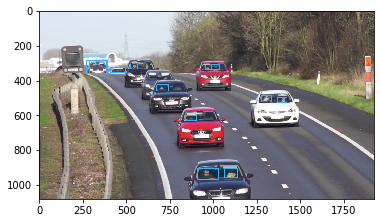

In [28]:
#차 안의 사람 검출
yolo=net.forward('yolo_106') #yolo_82,94,106

frame=cv2.imread("cars.jpg")
frameHeight=frame.shape[0]
frameWidth=frame.shape[1]

blob = cv2.dnn.blobFromImage(frame, 1/255, (inpWidth, inpHeight), [0,0,0], True, crop=False)
net.setInput(blob) #(이미지, scale filter, resize, 평균을 0으로 설정, T&F, 영상 사이즈가 맞지 않을때 자를지 결정)
# 0~1로 normalize? #True=(NCHW), False=(NHWC) /N=샘플의 개수,Channel,Height,Width
#print(blob.shape)=(1, 3, 416, 416) #blob=RGB channel

for i in range(len(yolo)):   
    detection = yolo[i]    
    scores = detection[5:]
    classId = np.argmax(scores)
    confidence = scores[classId]
    if confidence > 0.01:
        print(classes[classId])
        center_x = int(detection[0] * frameWidth)
        center_y = int(detection[1] * frameHeight)
        width = int(detection[2] * frameWidth)
        height = int(detection[3] * frameHeight)
        left = int(center_x - width / 2)
        top = int(center_y - height / 2)        
        cv2.rectangle(frame, (left, top), (left+width, top+height), (255, 178, 50), 3)
imshow("", frame)

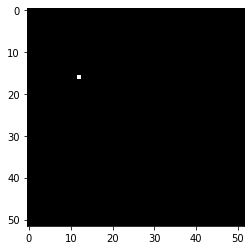

In [42]:
import math 

cells = []
for i in range(len(yolo)): #cell계산   
    detection = yolo[i]    
    scores = detection[5:]
    classId = np.argmax(scores)
    cells.append(classId)

np.random.randint(5, size=(80, 34))

#c = (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255))

cells = np.array(cells)
s = int(math.sqrt(len(yolo)/3)) #루트 연산
cells = cells.reshape(s,s,3) #3차원으로 만들어줌

img = cells[:,:,0]*70
imshow("", img)

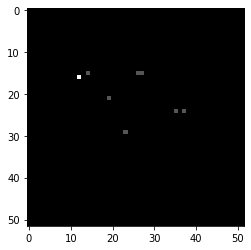

In [47]:
cells = []
for i in range(len(yolo)):   
    detection = yolo[i]    
    scores = detection[5:]
    classId = np.argmax(scores)
    confidence=scores[classId]
    if confidence>0.01: #사람 얼굴 검출
        cells.append(classId+1)
    else: #나머지는 제로
        cells.append(0)
    
np.random.randint(5, size=(80, 34))

#c = (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255))

cells = np.array(cells)
s = int(math.sqrt(len(yolo)/3))
cells = cells.reshape(s,s,3)

img = cells[:,:,0]*70
imshow("", img)

In [54]:
fourcc=cv2.VideoWriter_fourcc(*'mpv4')
out=cv2.VideoWriter('out.mp4',fourcc, 20.0,(640,480))

img1=cv2.imread('book1.jpg')
out.write(img1)

img1=cv2.imread('book2.jpg')
out.write(img1)

img1=cv2.imread('book3.jpg')
out.write(img1)

img1=cv2.imread('book4.jpg')
out.write(img1)

In [53]:
#*'什么' 사용법
def fun(a,b,c,d):
    print(a)
    print(b)
    print(c)
    print(d)
fun('m','p','v','4')
fun(*"mpv4")

m
p
v
4
m
p
v
4
